In [1]:
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.datasets import load_digits, make_sparse_coded_signal
from skimage.color import rgb2gray
from skimage import data
import matplotlib.pyplot as plt 
import numpy as np

from scipy.fft import fft2, ifft2

# helper function for forward operator
def K(inp,psf=[],mode='forward'):
    n = inp.shape[0]
    k_hat = fft2(psf,s=(n,n))
    inp_hat = fft2(inp)
    if mode == 'forward':
        outp = ifft2(k_hat * inp_hat)
    if mode == 'adjoint':
        outp = ifft2(np.conj(k_hat) * inp_hat)
    if mode == 'inv':
        outp = ifft2( np.conj(k_hat) * inp_hat / ( np.conj(k_hat) * k_hat ) )
        
    return np.real(outp)

# helper function for plotting
def plot_images(images, titles, fname=[], scale = [0,1]):
    m = len(images)
    fig, ax = plt.subplots(1,m)
    
    if m > 1:
        for k in range(m):
            ax[k].set_xticks([])
            ax[k].set_yticks([])
            ax[k].imshow(images[k], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
            ax[k].set_title(titles[k])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(images[0], cmap=plt.cm.gray, vmin=scale[0], vmax=scale[1])
        ax.set_title(titles[0])
    fig.set_figwidth(10)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname,dpi=300)
        
def squares_image(n):
    u = np.zeros((n,n))
    u[n//6:n//6+7*n//12, n//6:n//6+7*n//12] = .5
    u[2*n//3:2*n//3+n//6, 2*n//3:2*n//3+n//6] = 1
    
    return u

def show_data(U,m,n):
    fig, ax = plt.subplots(m,n)
    k = 0
    for i in range(m):
        for j in range(n):
            ax[i,j].imshow(U[k,:].reshape(8,8),cmap='gray')
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            k += 1
    fig.tight_layout()

# Dictionary learning

* Some images may be naturally sparse under different linear transforms
* We may not know a good transform, can we build one from a set of training images?

We need to solve

$$\min_{z, D} \sum_{i=1}^m \frac{1}{2}\|Dz_i - u_i\|_2^2 + \alpha \|z_i\|_1,$$

under suitable constraints on $D$.

In [ ]:
n_train = 100
n_test = 50

digits = load_digits()
U_train = digits.data[:n_train]
U_test = digits.data[n_train:n_train+n_test]

In [ ]:
show_data(U_train[:30],3,10)

In [ ]:
# initialise dictionary learner
dict_learner = MiniBatchDictionaryLearning(n_components=20, alpha = 1e1, transform_algorithm='lasso_lars', random_state=42)

# learn dictionary and fit
Z_train = dict_learner.fit_transform(U_train)

In [ ]:
# plot dictionary elements
show_data(dict_learner.components_,2,10)

In [ ]:
# compute testing error
Z_test = dict_learner.transform(U_test)

# compute sparsity level
print('NNZ:', np.mean(Z_test == 0)/64/n_test)

# compute training error (MSE)
U_hat = Z_test @ dict_learner.components_
print('MSE:', np.mean(np.sum((U_hat - U_test) ** 2, axis=1) / np.sum(U_test ** 2, axis=1)))

In [ ]:
plt.imshow(U_test[0].reshape(8,8),cmap='gray')

In [ ]:
plt.plot(Z_test[0])

In [ ]:
show_data(dict_learner.components_[np.abs(Z_test[0])>0],2,2)

# Practical aspects

* In practice, we would learn a dictionary of image patches

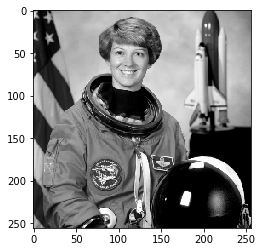

In [2]:
u = rgb2gray(data.astronaut())
u = u[::2,::2]
plt.imshow(u,cmap='gray')

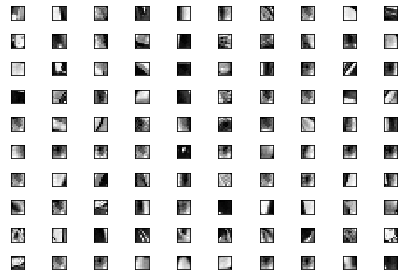

In [4]:
# extract patches
patches = extract_patches_2d(u,(8,8),max_patches=100)
patches = patches.reshape(patches.shape[0], -1)
patches -= np.mean(patches, axis=0)
patches /= np.std(patches, axis=0)
show_data(patches,10,10)

In [5]:
# initialise dictionary learner
dict_learner = MiniBatchDictionaryLearning(n_components=20, transform_alpha = 1e-3, random_state=42, transform_algorithm = 'lasso_lars')

# learn dictionary
dict_learner.fit(patches)

MiniBatchDictionaryLearning(n_components=20, random_state=42,
                            transform_algorithm='lasso_lars',
                            transform_alpha=0.001)

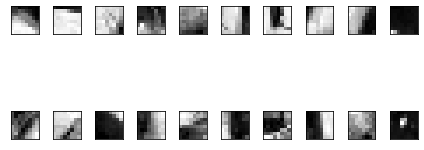

In [6]:
# show dictionary
show_data(dict_learner.components_,2,10)

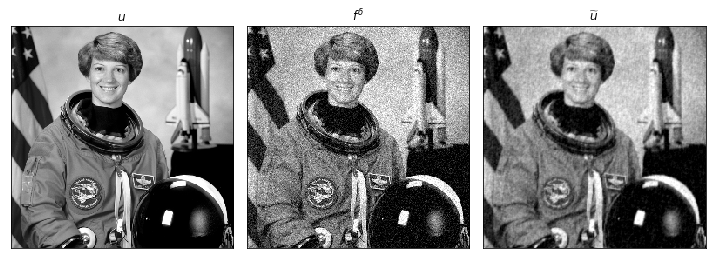

In [7]:
u = rgb2gray(data.astronaut())
u = u[::2,::2]
dd
delta = 1e-1
f_delta = u + delta * np.random.randn(u.shape[0],u.shape[1])

p_delta = extract_patches_2d(f_delta ,(8,8))
p_delta = p_delta.reshape(p_delta.shape[0], -1)

p = dict_learner.transform(p_delta) @ dict_learner.components_
#p = p_delta
image = reconstruct_from_patches_2d(p.reshape((p.shape[0],8,8)), (256,256))

plot_images([u,f_delta,image], [r'$u$',r'$f^\delta$',r'$\widetilde{u}$'])

# Assignment: data-driven vs model-driven

* how does the dictionary generalise to other images?
* compare the dictionary method to TV denoising